In [1]:
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

***Open with data***

In [2]:
with open('../DataBases/CD4EncodedBase.pkl', 'rb') as f:
    columns, CD4_Attributes, CD4_ClassResults = pickle.load(f)
with open('../Databases/VlEncodedBase.pkl', 'rb') as f:
    columns, VL_Attributes, VL_ClassResults = pickle.load(f)
with open('../DataBases/CD4EncodedBaseBalanced.pkl', 'rb') as f:
    columns, CD4_AttributesBalanced, CD4_ClassResultsBalanced = pickle.load(f)
with open('../Databases/VlEncodedBaseBalanced.pkl', 'rb') as f:
    columns, VL_AttributesBalanced, VL_ClassResultsBalanced = pickle.load(f)

***Generate training and test***

In [36]:
Cd4AttributesTraining, Cd4AttributesTest, Cd4ClassResultsTraining, Cd4ClassResultsTest = train_test_split(CD4_Attributes, CD4_ClassResults, test_size=0.2, random_state=0)
VlAttributesTraining, Vl4AttributesTest, VlClassResultsTraining, VlClassResultsTest = train_test_split(VL_Attributes, VL_ClassResults, test_size=0.2, random_state=0)
Cd4AttributesTrainingBalanced, Cd4AttributesTestBalanced, Cd4ClassResultsTrainingBalanced, Cd4ClassResultsTestBalanced = train_test_split(CD4_AttributesBalanced, CD4_ClassResultsBalanced, test_size=0.2, random_state=0)
VlAttributesTrainingBalanced, VlAttributesTestBalanced, VlClassResultsTrainingBalanced, VlClassResultsTestBalanced = train_test_split(VL_AttributesBalanced, VL_ClassResultsBalanced, test_size=0.2, random_state=0)

***GridSearch for Random Forest***

In [37]:
params = {
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [3, 5, 10, 20, 50, 100],
    'min_samples_leaf': [3, 5, 10, 20, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', None]
}

***Creating Grid***

In [38]:
grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

***Run Grid***

In [39]:
grid.fit(VL_AttributesBalanced, VL_ClassResultsBalanced)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 30, None],
                         'max_features': ['auto', None],
                         'min_samples_leaf': [3, 5, 10, 20, 50, 100],
                         'min_samples_split': [3, 5, 10, 20, 50, 100]},
             verbose=1)

In [40]:
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 20, 'min_samples_split': 50}
0.7428026493462782


***Criando e executando a Random Forest***

In [45]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='auto', min_samples_leaf=10, min_samples_split=10)
model = dtc.fit(VlAttributesTrainingBalanced, VlClassResultsTrainingBalanced)
dtc.score(VlAttributesTestBalanced, VlClassResultsTestBalanced)

c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


0.7185289957567186

***Analisando métricas da Random Forest criada***

c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


0.7185289957567186

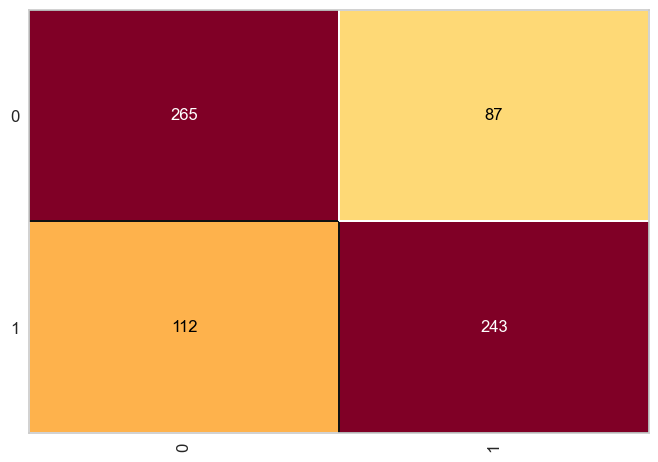

In [46]:
from sklearn.metrics import confusion_matrix

cm = ConfusionMatrix(model)
cm.score(VlAttributesTestBalanced, VlClassResultsTestBalanced)

In [47]:
y_pred = dtc.predict(VlAttributesTestBalanced)

# Generate classification report
report = classification_report(VlClassResultsTestBalanced, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.75      0.73       352
           1       0.74      0.68      0.71       355

    accuracy                           0.72       707
   macro avg       0.72      0.72      0.72       707
weighted avg       0.72      0.72      0.72       707

